# Variance optimization
This notebook demonstrates the effect of the relative error tolerance.

In [1]:
from qiskit import *
import numpy as np
import pylab as pl
import networkx as nx
from qiskit.visualization import *
from qiskit.providers.aer.noise import NoiseModel
from qiskit.test.mock import FakeOurense
from qaoa import *
from pylab import cm
from timeit import default_timer as timer

from matplotlib import rc,patches
from scipy import optimize as opt
from scipy import stats

# Parameters when sampling the entire parameter space
SAMPLING_E_ATOL = 4e-2
SAMPLING_E_RTOL = 5e-2
SAMPLING_DELTA_V_RTOL = 1e-1
MIN_SAMPLES = 128
MAX_SAMPLES = 31768*8
SAMPLING_CONF_IDX = 2
LANDSCAPE_RESOLUTION = 12

# Parameters for error tolerance iterations
N_INITIAL_GAMMA = 3
N_INITIAL_BETA = 2
N_REPS = 32
MIN_ALPHA = 0
MAX_ALPHA = 1
N_ALPHA = 5
N_INITIAL_POINTS = N_INITIAL_GAMMA * N_INITIAL_BETA

# Other parameters
CORRELATION_FRAC = 0.1
WEIGHT_DECIMALS = 1
NOISY = 0
MOCK = (NOISY == 2)
OPTIMIZATION_LEVEL = 2
GRAPH_SEED = 52
CIRCUIT_VERSION = 1
CIRCUIT_DEPTH = 1

font = {'size' : 16}
rc('font', **font);
rc('text', usetex=True)

100%
Max cost: 2


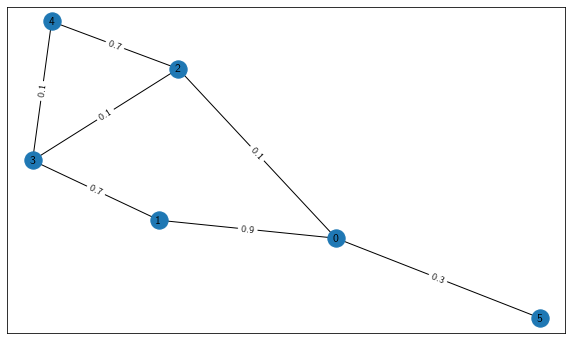

In [2]:
V = np.arange(0,6,1)
E =[(0,1),(0,2),(2,3),(3,1),(3,4),(4,2),(5,0)]
G = nx.Graph()
G.add_nodes_from(V)
G.add_edges_from(E)

np.random.seed(GRAPH_SEED)
addWeights_MaxCut(G,decimals=WEIGHT_DECIMALS)

pl.figure(figsize=(10,6))
pos = nx.spring_layout(G)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx(G,pos)
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

V1 = np.arange(0,)
costs=costsHist_MaxCut(G)
max_cost = max(costs)
print('Max cost: %d' % max_cost)

In [3]:
execute_backend = Aer.get_backend('qasm_simulator')

if NOISY == 1:
    IBMQ.load_account()
    provider = IBMQ.get_provider(hub='ibm-q')
    noise_backend = provider.get_backend('ibmq_ourense')
    transpile_backend = noise_backend
elif NOISY == 2:
    execute_backend = FakeOurense()
    transpile_backend = execute_backend
    noise_backend = execute_backend
else:
    noise_backend = None
    transpile_backend = execute_backend
    
if noise_backend == None:
    noise_model = None
else:
    noise_model = NoiseModel.from_backend(noise_backend.properties())

Prepare the initial points from which we will do the optimizations.

In [4]:
(gamma_min,gamma_max),(beta_min,beta_max) = parameterBounds_MaxCut(G,decimals=WEIGHT_DECIMALS)
gamma_period = (gamma_max-gamma_min)*2
beta_period = beta_max-beta_min

delta_gamma = (gamma_max-gamma_min)/N_INITIAL_GAMMA
delta_beta = (beta_max-beta_min)/N_INITIAL_BETA

initial_points = np.mgrid[gamma_min+delta_gamma/2:gamma_max-delta_gamma/2:N_INITIAL_GAMMA*1j,
                          beta_min+delta_beta/2:beta_max-delta_beta/2:N_INITIAL_BETA*1j]
initial_gammas = initial_points[0,:].flatten()
initial_betas = initial_points[1,:].flatten()

Now we sample the entire parameter space landscape and find the cost value at each point.

In [5]:
# Use the weights to find the typical Fourier frequency. Then pick LANDSCAPE_RESOLUTION points
# within each sinusoid oscillation at this frequency.
gamma_typ_freq,beta_typ_freq = spatialFrequencies_MaxCut(G)

landscape_n_gamma = int(gamma_period*LANDSCAPE_RESOLUTION*np.ceil(gamma_typ_freq))
landscape_n_beta = int(beta_period*LANDSCAPE_RESOLUTION*np.ceil(beta_typ_freq))

print('landscape_n_gamma: %d' % landscape_n_gamma)
print('landscape_n_beta: %d' % landscape_n_beta)

gammas_landscape = np.linspace(gamma_min,gamma_max,landscape_n_gamma)
betas_landscape = np.linspace(beta_min,beta_max,landscape_n_beta)

E_landscape = np.zeros((landscape_n_beta,landscape_n_gamma))
v_landscape = np.zeros((landscape_n_beta,landscape_n_gamma))
shot_landscape = np.zeros((landscape_n_beta,landscape_n_gamma))

timer_start = timer()
circuits=[]
for i in range(landscape_n_beta):
    for j in range(landscape_n_gamma):
        beta = betas_landscape[i]
        gamma = gammas_landscape[j]
        circuit = createCircuit_MaxCut(np.array((gamma,beta)),G,CIRCUIT_DEPTH,CIRCUIT_VERSION)
        
        transpiled_circuit = transpile(circuit,backend=transpile_backend,optimization_level=OPTIMIZATION_LEVEL)
        [E_list,v_list,shot_list] = sampleUntilPrecision_MaxCut(transpiled_circuit,G,execute_backend,noise_model,
                                                                MIN_SAMPLES,MAX_SAMPLES,SAMPLING_E_ATOL,
                                                                SAMPLING_E_RTOL,SAMPLING_DELTA_V_RTOL,
                                                                SAMPLING_CONF_IDX,mock=MOCK)
        E_landscape[i,j] = -E_list[-1]
        v_landscape[i,j] = v_list[-1]
        shot_landscape[i,j] = sum(shot_list)
        
        timer_end = timer()
        progress = (i*landscape_n_gamma+j+1)/(landscape_n_gamma*landscape_n_beta)
        remaining_time = (timer_end-timer_start)*(1/progress-1)
        print('%.2f%% (T-%.2f sec)' % (progress*100,remaining_time),end='\r')
        

landscape_n_gamma: 753
landscape_n_beta: 18


In [6]:
grad_Es = np.gradient(E_landscape)
grad_E_landscape = np.zeros_like(E_landscape)
for dim in range(2):
    grad_E_landscape += grad_Es[dim]**2
grad_E_landscape = np.sqrt(grad_E_landscape)

grad_vs = np.gradient(v_landscape)
grad_v_landscape = np.zeros_like(v_landscape)
for dim in range(2):
    grad_v_landscape += grad_vs[dim]**2
grad_v_landscape = np.sqrt(grad_v_landscape)

s_landscape = np.sqrt(v_landscape)
grad_ss = np.gradient(s_landscape)
grad_s_landscape = np.zeros_like(s_landscape)
for dim in range(2):
    grad_s_landscape += grad_ss[dim]**2

corr_hw_beta = int(np.ceil(CORRELATION_FRAC/2*landscape_n_beta))
corr_hw_gamma = int(np.ceil(CORRELATION_FRAC/2*landscape_n_gamma))

r_landscape = np.zeros_like(E_landscape)
p_landscape = np.zeros_like(E_landscape)
for i in range(corr_hw_beta,landscape_n_beta-corr_hw_beta):
    for j in range(corr_hw_gamma,landscape_n_gamma-corr_hw_gamma):
        corr_betas = range(i-corr_hw_beta,i+corr_hw_beta)
        corr_gammas = range(j-corr_hw_gamma,j+corr_hw_gamma)
        corr_Es = E_landscape[i-corr_hw_beta:i+corr_hw_beta,j-corr_hw_gamma:j+corr_hw_gamma].flatten()
        corr_vs = v_landscape[i-corr_hw_beta:i+corr_hw_beta,j-corr_hw_gamma:j+corr_hw_gamma].flatten()
        slope, _, r_value, p_value, std_err = stats.linregress(corr_Es,corr_vs)
        r_landscape[i,j] = r_value
        p_landscape[i,j] = p_value
        
grad_rs = np.gradient(r_landscape)
grad_r_landscape = np.zeros_like(r_landscape)
for dim in range(2):
    grad_r_landscape += grad_rs[dim]**2

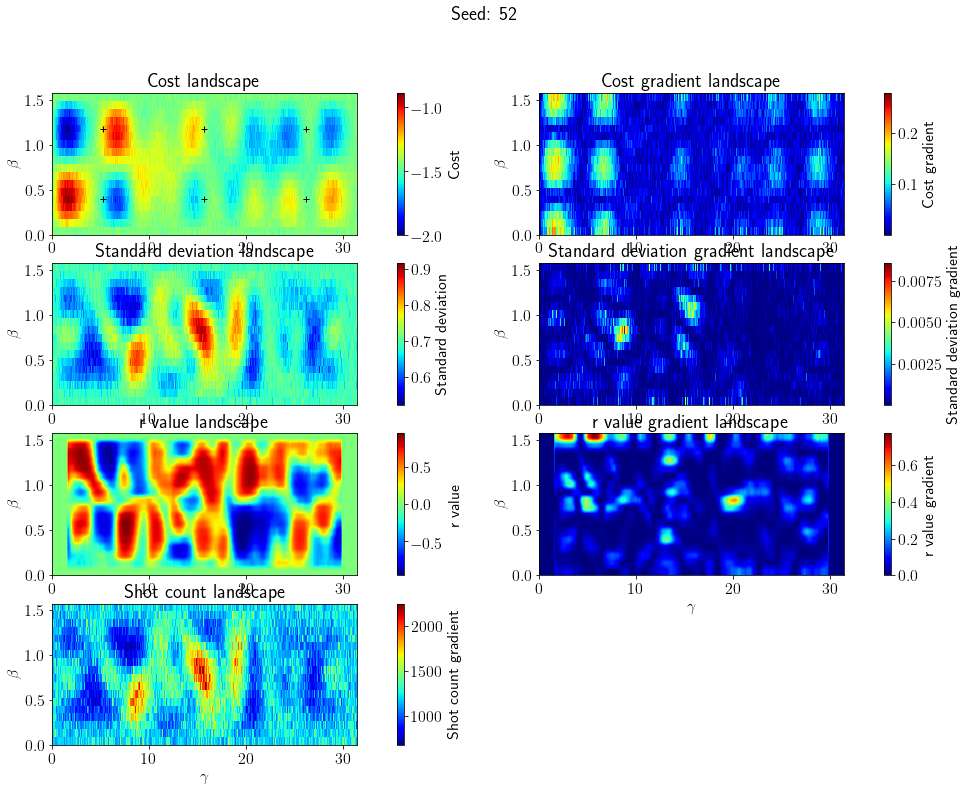

In [7]:
pl.figure(figsize=(16, 12))

pl.subplot(4,2,1)
pl.imshow(np.array(E_landscape).reshape(landscape_n_beta,landscape_n_gamma),
          origin='lower',interpolation='nearest',cmap=cm.jet,aspect='auto',
          extent=[gammas_landscape[0],gammas_landscape[-1],betas_landscape[0],betas_landscape[-1]])
pl.plot(initial_gammas,initial_betas,'k+')
cbar = pl.colorbar(orientation="vertical", pad=0.1)
cbar.set_label('Cost')
pl.xlabel(r'$\gamma$')
pl.ylabel(r'$\beta$')
pl.title('Cost landscape')

pl.subplot(4,2,2)
pl.imshow(np.array(grad_E_landscape).reshape(landscape_n_beta,landscape_n_gamma),
          origin='lower',interpolation='nearest',cmap=cm.jet,aspect='auto',
          extent=[gammas_landscape[0],gammas_landscape[-1],betas_landscape[0],betas_landscape[-1]])
cbar = pl.colorbar(orientation="vertical", pad=0.1)
cbar.set_label('Cost gradient')
pl.xlabel(r'$\gamma$')
pl.ylabel(r'$\beta$')
pl.title('Cost gradient landscape')

pl.subplot(4,2,3)
pl.imshow(np.array(s_landscape).reshape(landscape_n_beta,landscape_n_gamma),
          origin='lower',interpolation='nearest',cmap=cm.jet,aspect='auto',
          extent=[gammas_landscape[0],gammas_landscape[-1],betas_landscape[0],betas_landscape[-1]])
cbar = pl.colorbar(orientation="vertical", pad=0.1)
cbar.set_label('Standard deviation')
pl.xlabel(r'$\gamma$')
pl.ylabel(r'$\beta$')
pl.title('Standard deviation landscape')

pl.subplot(4,2,4)
pl.imshow(np.array(grad_s_landscape).reshape(landscape_n_beta,landscape_n_gamma),
          origin='lower',interpolation='nearest',cmap=cm.jet,aspect='auto',
          extent=[gammas_landscape[0],gammas_landscape[-1],betas_landscape[0],betas_landscape[-1]])
cbar = pl.colorbar(orientation="vertical", pad=0.1)
cbar.set_label('Standard deviation gradient')
pl.xlabel(r'$\gamma$')
pl.ylabel(r'$\beta$')
pl.title('Standard deviation gradient landscape')

pl.subplot(4,2,5)
pl.imshow(np.array(r_landscape).reshape(landscape_n_beta,landscape_n_gamma),
          origin='lower',cmap=cm.jet,aspect='auto',
          extent=[gammas_landscape[0],gammas_landscape[-1],betas_landscape[0],betas_landscape[-1]])
cbar = pl.colorbar(orientation="vertical", pad=0.1)
cbar.set_label('r value')
pl.xlabel(r'$\gamma$')
pl.ylabel(r'$\beta$')
pl.title('r value landscape')

pl.subplot(4,2,6)
pl.imshow(np.array(grad_r_landscape).reshape(landscape_n_beta,landscape_n_gamma),
          origin='lower',cmap=cm.jet,aspect='auto',
          extent=[gammas_landscape[0],gammas_landscape[-1],betas_landscape[0],betas_landscape[-1]])
cbar = pl.colorbar(orientation="vertical", pad=0.1)
cbar.set_label('r value gradient')
pl.xlabel(r'$\gamma$')
pl.ylabel(r'$\beta$')
pl.title('r value gradient landscape')

pl.subplot(4,2,7)
pl.imshow(np.array(shot_landscape).reshape(landscape_n_beta,landscape_n_gamma),
          origin='lower',interpolation='nearest',cmap=cm.jet,aspect='auto',
          extent=[gammas_landscape[0],gammas_landscape[-1],betas_landscape[0],betas_landscape[-1]])
cbar = pl.colorbar(orientation="vertical", pad=0.1)
cbar.set_label('Shot count gradient')
pl.xlabel(r'$\gamma$')
pl.ylabel(r'$\beta$')
pl.title('Shot count landscape')

pl.suptitle('Seed: %d'%GRAPH_SEED)

fig_idx = 9
pl.savefig('var_optimization_landscape_noisy%d_opt%d_fig%d.png'%(NOISY,OPTIMIZATION_LEVEL,fig_idx))
pl.tight_layout()

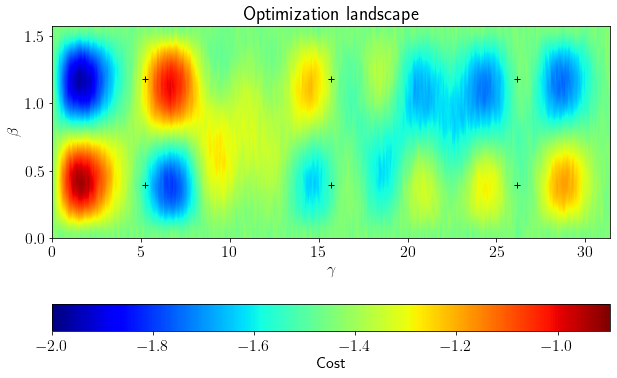

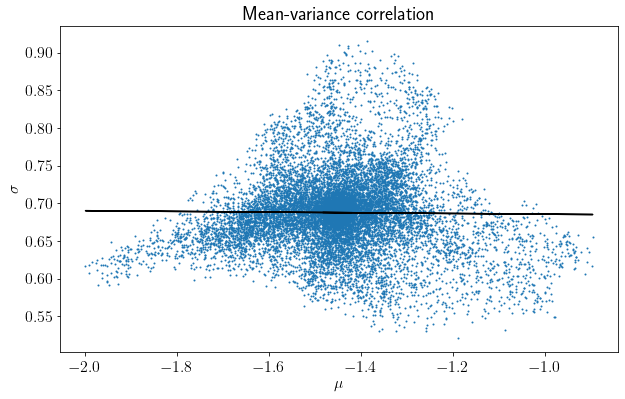

In [8]:
pl.figure(figsize=(10,6))
pl.imshow(np.array(E_landscape).reshape(landscape_n_beta,landscape_n_gamma),
          origin='lower',interpolation='bicubic',cmap=cm.jet,aspect='auto',
          extent=[gammas_landscape[0],gammas_landscape[-1],betas_landscape[0],betas_landscape[-1]])
pl.plot(initial_gammas,initial_betas,'k+')
cbar = pl.colorbar(orientation="horizontal", pad=0.2)
cbar.set_label('Cost')

pl.xlabel(r'$\gamma$')
pl.ylabel(r'$\beta$')
pl.title('Optimization landscape')

Es = E_landscape.flatten()
ss = np.sqrt(v_landscape).flatten()
m,b = np.polyfit(Es,ss,1)

pl.figure(figsize=(10,6))
pl.scatter(Es,ss,s=1)
pl.plot(Es,m*Es+b,'k')
pl.xlabel('$\\mu$')
pl.ylabel('$\\sigma$')
pl.title('Mean-variance correlation')
pl.savefig('mu-sigma_correlation.png')

Now we iterate over each of **N_ALPHA** alphas. For each of them, do **N_REPS** optimization runs at each of the **N_INITIAL_POINTS** parameters space lattice points.

In [9]:
# Alpha denotes the relative expectation-variance weighting in the cost function
def getval(x,history_ref,execute_backend,depth,version,noise_model,E_atol,E_rtol,dv_rtol,
           min_n_shots,max_n_shots,conf_idx,alpha,mock,optimization_level):
    circuit = createCircuit_MaxCut(x,G,depth,version)
    
    transpiled_circuit = transpile(circuit,backend=transpile_backend,optimization_level=optimization_level)
    [E_list,v_list,n_list] = sampleUntilPrecision_MaxCut(transpiled_circuit,G,execute_backend,noise_model,
                                                                min_n_shots,max_n_shots,E_atol,E_rtol,dv_rtol,
                                                                conf_idx,mock=mock)

    history_ref['gammas'].append(x[0])
    history_ref['betas'].append(x[1])
    history_ref['expectations'].append(E_list)
    history_ref['variances'].append(v_list)
    history_ref['n_shots'].append(n_list)
        
    return -(1-alpha)*E_list[-1]+alpha*v_list[-1]

In [10]:
alphas = np.linspace(MIN_ALPHA,MAX_ALPHA,N_ALPHA)

opt_histories = []
remaining_time = np.inf
timer_start = timer()
for i in range(N_ALPHA):
    alpha = alphas[i]
    
    opt_histories.append([])
    for j in range(N_INITIAL_POINTS):
        x0 = (initial_gammas[j],initial_betas[j])
        
        opt_histories[i].append([])
        for k in range(N_REPS):
        
            opt_history = {
                'gammas': [],
                'betas': [],
                'expectations': [],
                'variances': [],
                'n_shots': [],
            }
            opt.minimize(getval, x0=x0, method='COBYLA',
                             args=(opt_history,execute_backend,CIRCUIT_DEPTH,CIRCUIT_VERSION,noise_model,
                                   SAMPLING_E_ATOL,SAMPLING_E_RTOL,SAMPLING_DELTA_V_RTOL,
                                   MIN_SAMPLES,MAX_SAMPLES,SAMPLING_CONF_IDX,alpha,MOCK,OPTIMIZATION_LEVEL),
                             options={'rhobeg': 1e0, 'disp': True, 'maxiter': 10000})
            
            opt_histories[i][j].append(opt_history)  
            
            timer_end = timer()
            progress = (i*N_INITIAL_POINTS*N_REPS+j*N_REPS+k+1)/(N_ALPHA*N_INITIAL_POINTS*N_REPS)
            remaining_time = (timer_end-timer_start)*(1/progress-1)
            print('%.2f%% (T-%.2f sec)' % (progress*100,remaining_time),end='\r')
            


Let us verify that the optimizations seem to work correctly.

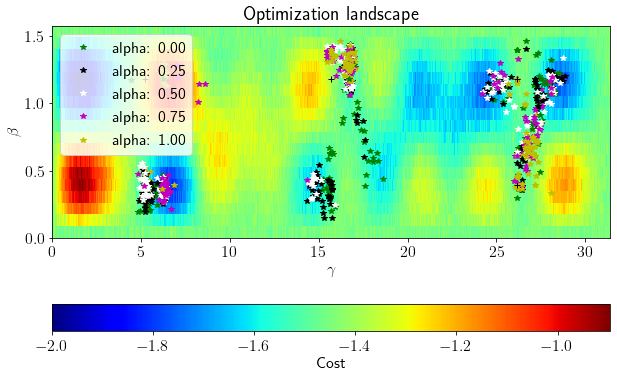

In [11]:
pl.figure(figsize=(10,6))
pl.imshow(np.array(E_landscape).reshape(landscape_n_beta,landscape_n_gamma),
          origin='lower',interpolation='nearest',cmap=cm.jet,aspect='auto',
          extent=[gammas_landscape[0],gammas_landscape[-1],betas_landscape[0],betas_landscape[-1]])

colors = 'gkwmy'
for j in range(N_INITIAL_POINTS):
    for i in range(N_ALPHA):
        alpha = alphas[i]
        for k in range(N_REPS):
            gammas = list(opt_history['gammas'])
            betas = list(opt_history['betas'])
            for it in range(len(gammas)):
                gammas[it],betas[it] = wrapParameters_MaxCut(gammas[it],betas[it],
                                                             (gamma_min,gamma_max),
                                                             (beta_min,beta_max))
            opt_history = opt_histories[i][j][k]
            
            label = None
            if k == N_REPS-1 and j == N_INITIAL_POINTS-1:
                label = 'alpha: %.2f'%alpha
            pl.plot(gammas[-1],betas[-1],str(colors[i]+'*'),linewidth=0.3,label=label)
    pl.plot(initial_gammas[j],initial_betas[j],'k+')

cbar = pl.colorbar(orientation="horizontal", pad=0.2)
cbar.set_label('Cost')

pl.xlabel(r'$\gamma$')
pl.ylabel(r'$\beta$')
pl.title('Optimization landscape')
pl.legend()

Finally we plot histograms for the achieved optimization ratios, as well as iterations and total shots per optimization.

<Figure size 432x288 with 0 Axes>

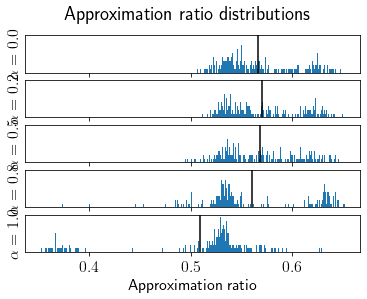

<Figure size 432x288 with 0 Axes>

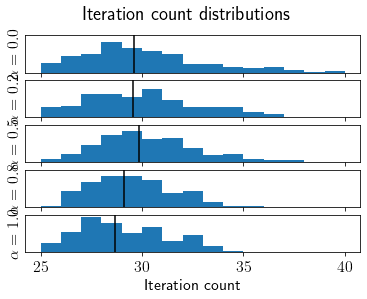

<Figure size 432x288 with 0 Axes>

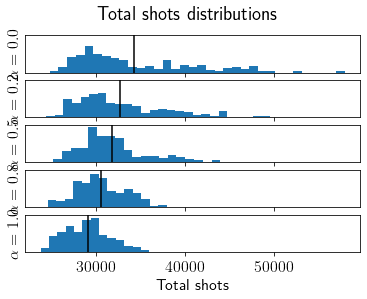

In [12]:
n_datapoints = N_REPS*N_INITIAL_POINTS

apx_ratios = np.zeros((N_ALPHA,n_datapoints))
n_itss = np.zeros((N_ALPHA,n_datapoints))
n_shotss = np.zeros((N_ALPHA,n_datapoints))


for i in range(N_ALPHA):
    for j in range(N_INITIAL_POINTS):
        for k in range(N_REPS):
            opt_history = opt_histories[i][j][k]
            
            n_shots_list = [sum(x) for x in opt_history['n_shots']]
            E = opt_history['expectations'][-1]
            
            tot_n_shots = sum(n_shots_list)
            n_its = len(n_shots_list)
            apx_ratio = E[-1]/max_cost

            flat_idx = j*N_REPS + k
            apx_ratios[i,flat_idx] = apx_ratio
            n_itss[i,flat_idx] = n_its
            n_shotss[i,flat_idx] = tot_n_shots
            
pl.figure()
_,axs = pl.subplots(N_ALPHA,1,sharex=True,sharey='col')
for i in range(N_ALPHA):
    binsize = 0.001
    apx_ratios_flat = apx_ratios[i].flatten()
    n_bins = int(np.ceil((max(apx_ratios_flat)-min(apx_ratios_flat))/binsize))
    
    axs[i].hist(apx_ratios_flat,n_bins,label='Distribution, $\\alpha=%.2e$'%alphas[i])
    axs[i].axvline(np.average(apx_ratios_flat),color='k')
    axs[i].set_ylabel('$\\alpha = %.1f$' % alphas[i])
    axs[i].set_yticks([])
pl.xlabel('Approximation ratio')
pl.suptitle('Approximation ratio distributions')
pl.savefig('var_alpha_E_pdf.svg')

pl.figure()
_,axs = pl.subplots(N_ALPHA,1,sharex=True,sharey='col')
for i in range(N_ALPHA):
    binsize = 1
    n_its_flat = n_itss[i].flatten()
    n_bins = int(np.ceil((max(n_its_flat)-min(n_its_flat))/binsize))
    
    axs[i].hist(n_its_flat,n_bins,label='Distribution, $\\alpha=%.2e$'%alphas[i])
    axs[i].axvline(np.average(n_its_flat),color='k')
    axs[i].set_ylabel('$\\alpha=%.1f$' % alphas[i])
    axs[i].set_yticks([])
pl.xlabel('Iteration count')
pl.suptitle('Iteration count distributions')
pl.savefig('var_alpha_its_pdf.svg')

pl.figure()
_,axs = pl.subplots(N_ALPHA,1,sharex=True,sharey='col')
for i in range(N_ALPHA):
    binsize = 1000
    n_shots_flat = n_shotss[i].flatten()
    n_bins = int(np.ceil((max(n_shots_flat)-min(n_shots_flat))/binsize))
    
    axs[i].hist(n_shots_flat,n_bins,label='Distribution, $\\alpha=%.2e$'%alphas[i])
    axs[i].axvline(np.average(n_shots_flat),color='k')
    axs[i].set_ylabel('$\\alpha=%.1f$' % alphas[i])
    axs[i].set_yticks([])
pl.xlabel('Total shots')
pl.suptitle('Total shots distributions')
pl.savefig('var_alpha_shots_pdf.svg')
pl.savefig('var_alpha_shots_pdf.png')